*Cost Operation Variable Variable, Hierarchical Complete*

In [1]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt

import glob
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.dates as mdates

calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Loads all SPORE NetCDF files, extracts and aggregates the capacity factor data for each configuration, and constructs a matrix where each row is a SPORE configuration and each column is a timestep.

In [2]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_df = data['cost_operation_variable'].to_dataframe().reset_index()
    # data_df = data_df[~data_df['techs'].str.contains(r'_to_', regex=True)]
    data_df = data_df.dropna(subset=['cost_operation_variable'])
    data_df['cost_operation_variable'] = data_df['cost_operation_variable'] / 3

    aggregated_flow_cap = data_df.groupby(['timesteps'])['cost_operation_variable'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_flow_cap.set_index('timesteps')['cost_operation_variable']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_flow_cap['timesteps']

# Show the resulting matrix
aggregated_matrix


timesteps,2019-01-01 00:00:00,2019-01-01 03:00:00,2019-01-01 06:00:00,2019-01-01 09:00:00,2019-01-01 12:00:00,2019-01-01 15:00:00,2019-01-01 18:00:00,2019-01-01 21:00:00,2019-01-02 00:00:00,2019-01-02 03:00:00,...,2019-12-30 18:00:00,2019-12-30 21:00:00,2019-12-31 00:00:00,2019-12-31 03:00:00,2019-12-31 06:00:00,2019-12-31 09:00:00,2019-12-31 12:00:00,2019-12-31 15:00:00,2019-12-31 18:00:00,2019-12-31 21:00:00
spore_5,2354.554747,2235.835966,2278.058704,2094.035956,2057.844228,2420.198130,2307.547686,2160.612301,2076.199774,2201.636450,...,2812.866003,2717.997774,2643.661261,2725.425065,3027.412098,2735.435824,2710.685739,3177.078566,2980.788720,2854.753824
minons_spore_8,2256.597959,2137.896714,2180.194597,1996.237079,1960.107405,2322.541042,2209.951422,2062.816856,1978.201469,2103.836076,...,2715.425454,2619.973660,2545.401898,2627.332297,2929.498340,2637.439918,2612.531754,3078.371824,2882.480752,2757.016056
minoff_spore_7,2400.938892,2282.661108,2324.764040,1954.837124,1995.234011,2467.059118,2354.477674,2208.003265,2123.635367,2248.737535,...,2860.926167,2765.651292,2690.804719,2773.148087,3074.072267,2786.889398,2760.276512,3220.928924,3025.847208,2900.916154
maxpv_spore_3,50.302992,-68.390511,-26.271574,-290.043032,-458.204656,114.643918,3.472279,-143.524569,-228.107489,-102.518413,...,1654.087443,1282.081613,988.674232,1315.149704,1981.045233,785.794608,496.254860,2135.631437,1941.334162,1815.842698
maxbat_spore_3,-229.199471,-347.786499,-305.548823,-489.404975,-525.499375,-163.422198,-275.767749,-422.732093,-507.301097,-381.792295,...,313.191343,133.680592,62.283387,215.390888,686.884660,212.524826,200.178421,836.025057,656.851511,504.093286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
minpv_spore_4,2036.158428,1917.624569,1959.139359,1782.128965,1738.422569,2100.977507,1989.436034,1842.576351,1758.093013,1883.653468,...,2496.230966,2398.587324,2324.182666,2405.604243,2709.704842,2417.006722,2390.659240,2855.852028,2662.032987,2538.020940
maxoff_spore_5,-382.113383,-525.901638,-511.884242,-689.692434,-734.622768,-452.563977,-623.425545,-745.360369,-806.833534,-660.058247,...,367.237428,327.665688,121.172036,473.866829,1333.373671,681.149186,637.725788,1497.563177,1263.017199,1098.552641
minbat_spore_1,300.470246,160.637345,205.660280,4.320610,-34.182120,369.429114,233.374939,60.429885,-37.332969,117.214050,...,1042.715388,846.595922,741.391295,944.942203,1587.548776,1009.068412,964.410913,1719.955049,1539.362549,1199.495748
maxbio_spore_10,-224.034615,-329.598756,-289.087345,-439.066238,-476.218041,-153.438525,-256.462540,-385.875600,-457.119258,-354.046508,...,197.454583,115.866937,45.189543,119.817123,287.952569,135.240728,123.607674,501.676380,291.605737,222.802546


Standardizes (normalizes) the aggregated matrix across all technologies using `StandardScaler` to prepare for clustering.

In [3]:
# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies

Computes the pairwise Euclidean distance matrix between all SPORE configurations based on the standardized data.

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(matrix_scaled)
# Compute the pairwise Euclidean distance matrix
distance_matrix = pdist(X_pca, metric='euclidean')

# Convert the distance matrix into a square form (for plotting)
distance_matrix_square = squareform(distance_matrix)


Performs hierarchical/agglomerative clustering (Ward's method) on the distance matrix to build a linkage matrix for cluster analysis.

In [5]:
from scipy.cluster.hierarchy import linkage

# Perform hierarchical/agglomerative clustering using Ward's method
Z = linkage(distance_matrix, method='complete')  # `ward` minimizes the variance within clusters


Plots a dendrogram to visualize the hierarchical clustering structure and relationships between SPORE configurations.

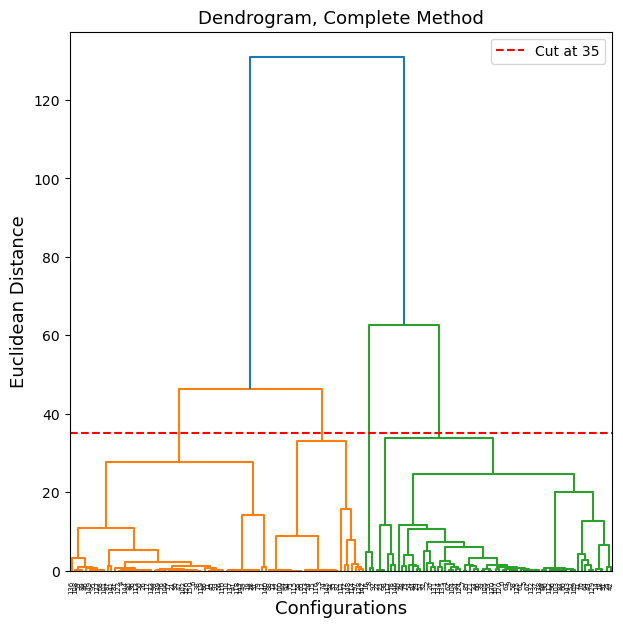

In [7]:
from scipy.cluster.hierarchy import dendrogram

# Plot the dendrogram
plt.figure(figsize=(7, 7))
dendrogram(Z)
plt.title('Dendrogram, Complete Method', size=13)
plt.xlabel('Configurations', size=13)

plt.axhline(y=35, color='r', linestyle='--', label='Cut at 35')
plt.legend()

plt.ylabel('Euclidean Distance', size=13)
plt.show()


Assigns cluster labels to each configuration based on a maximum distance threshold and adds these labels to the aggregated matrix.

In [13]:
from scipy.cluster.hierarchy import fcluster

# Define the maximum distance threshold (e.g., 50)
max_distance = 35
clusters = fcluster(Z, max_distance, criterion='distance')

# Add the cluster labels to the DataFrame
aggregated_matrix['Cluster_Hierarchical'] = clusters


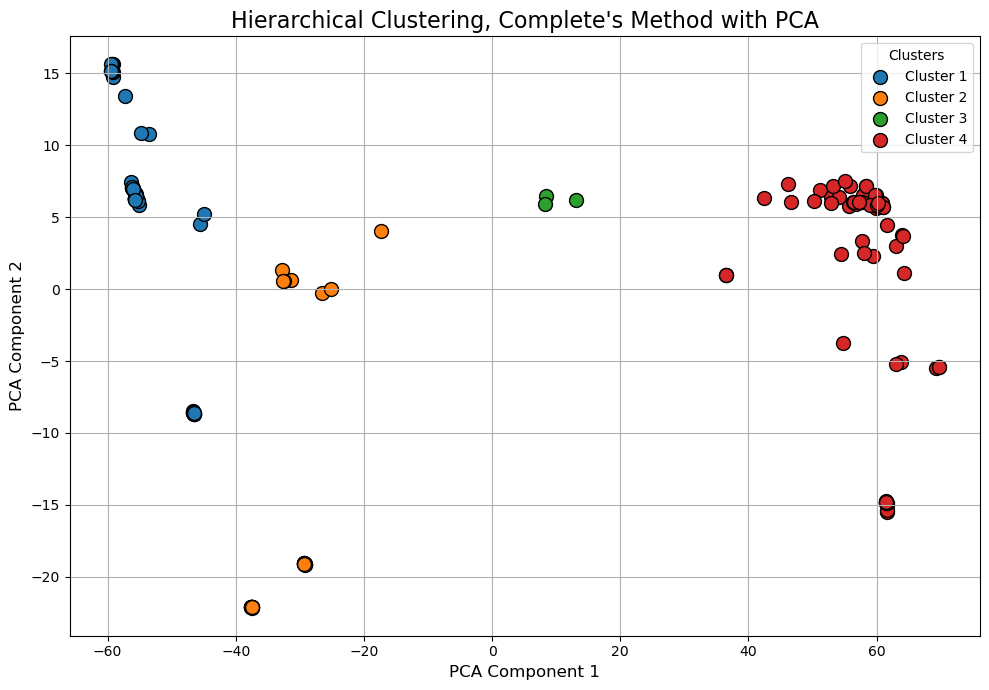

In [14]:
# Create a list of markers for each cluster
markers = ['o']  # Add more as needed

# Plot the clusters with different markers
plt.figure(figsize=(10, 7))
for i, cluster in enumerate(np.unique(aggregated_matrix['Cluster_Hierarchical'])):
    plt.scatter(X_pca[aggregated_matrix['Cluster_Hierarchical'] == cluster, 0], 
                X_pca[aggregated_matrix['Cluster_Hierarchical'] == cluster, 1], 
                label=f'Cluster {cluster}', 
                marker=markers[i % len(markers)], s=100, edgecolor='k')

# Add titles and labels
plt.title('Hierarchical Clustering, Complete\'s Method with PCA', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Show the plot
plt.legend(title="Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

[2025-06-15 14:37:40] WARNING  /var/folders/cr/z401r1016cvdgb_bngn5brwh0000gn/T/ipykernel_2157/2364601798.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters_p))



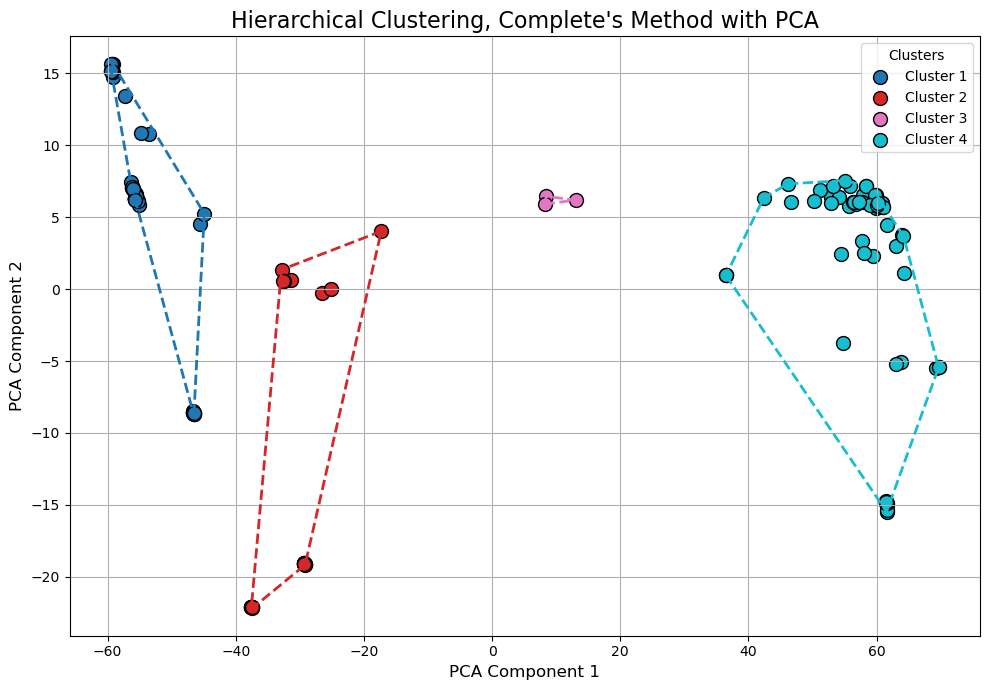

In [15]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

markers = ['o']  # Add more if you want variety
clusters_p = np.unique(aggregated_matrix['Cluster_Hierarchical'])

plt.figure(figsize=(10, 7))
colors = plt.cm.get_cmap('tab10', len(clusters_p))

for i, cluster in enumerate(clusters_p):
    mask = aggregated_matrix['Cluster_Hierarchical'] == cluster
    X_cluster = X_pca[mask]

    # Plot points
    plt.scatter(X_cluster[:, 0], X_cluster[:, 1],
                label=f'Cluster {cluster}',
                marker=markers[i % len(markers)], s=100,
                edgecolor='k', color=colors(i))

    # Plot convex hull polygon (if enough points)
    if len(X_cluster) >= 3:
        hull = ConvexHull(X_cluster)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # to close the polygon
        plt.plot(X_cluster[hull_points, 0], X_cluster[hull_points, 1],
                 linestyle='--', linewidth=2, color=colors(i))

# Titles and labels
plt.title("Hierarchical Clustering, Complete's Method with PCA", fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title="Clusters")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Define thresholds manually or as percentiles
pc1_threshold = np.percentile(X_pca[:, 0], 25)  # low PC1 (left)
pc2_threshold = np.percentile(X_pca[:, 1], 95)  # high PC2 (top)

# Create mask
mask = (X_pca[:, 0] < pc1_threshold) & (X_pca[:, 1] > pc2_threshold)

# Retrieve SPOREs from original matrix
selected_spores = aggregated_matrix[mask]


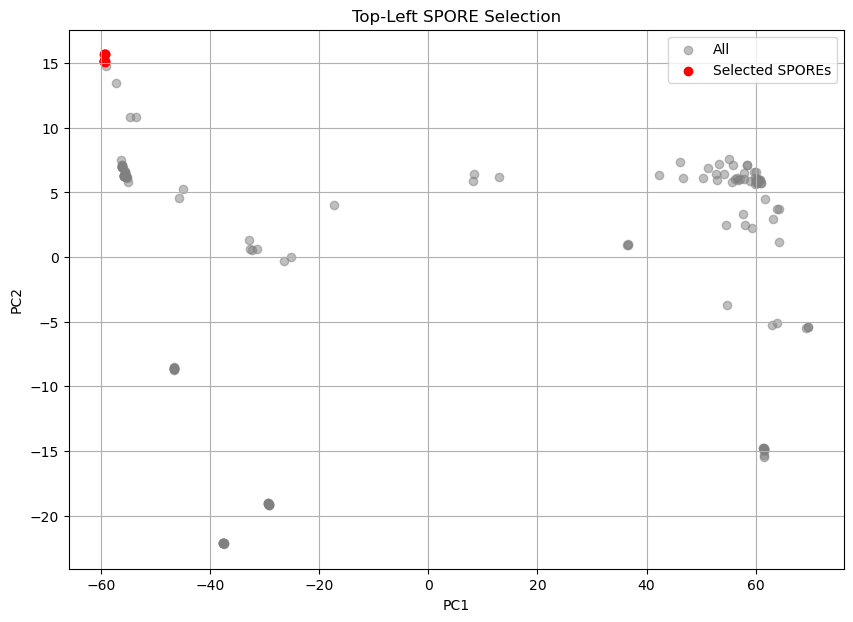

In [17]:
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='gray', alpha=0.5, label='All')
plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c='red', label='Selected SPOREs')
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.title("Top-Left SPORE Selection")
plt.show()


In [18]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score

db_score = davies_bouldin_score(X_pca, clusters)
print(f"Davies-Bouldin score: {db_score:.3f}")
db_score_orig = davies_bouldin_score(matrix_scaled, clusters)
print(f"DB score on original space: {db_score_orig:.3f}")

# Clusters from PCA-based clustering
ch_score_pca = calinski_harabasz_score(X_pca, clusters)
print(f"CH score on PCA space: {ch_score_pca:.2f}")
ch_score_orig = calinski_harabasz_score(matrix_scaled, clusters)
print(f"CH score on original space: {ch_score_orig:.2f}")


score = silhouette_score(X_pca, clusters)
print(f'Silhouette score: {score:.3f}')
sh_score_orig = silhouette_score(matrix_scaled, clusters)
print(f"SC score on original space: {sh_score_orig:.3f}")

metrics_summary = {
    'Davies-Bouldin': db_score_orig,
    'Calinski-Harabasz': ch_score_orig,
    'Silhouette': sh_score_orig
}
metrics_summary = pd.DataFrame({
    'score': ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz'],
    'value': [sh_score_orig, db_score_orig, ch_score_orig]
})

Davies-Bouldin score: 0.384
DB score on original space: 0.587
CH score on PCA space: 1459.71
CH score on original space: 965.48
Silhouette score: 0.694
SC score on original space: 0.644


Groups configurations by cluster and general SPORE category, then counts the number of configurations in each group to summarize cluster composition.

In [19]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster_Hierarchical', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count['spore_main'] = cluster_spore_count[['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10']].sum(axis=1)
cluster_spore_count = cluster_spore_count.drop(columns=['spore_1', 'spore_2', 'spore_3', 'spore_4', 'spore_5', 'spore_6', 'spore_7', 'spore_8', 'spore_9', 'spore_10'])

cluster_spore_count

spore_category_general,maxbat,maxbio,maxhtp,maxnuc,maxoff,maxons,maxpv,minbat,minbio,minhtp,minnuc,minoff,minons,minpv,spore_baseline,spore_main
Cluster_Hierarchical,,,,,,,,,,,,,,,,
1,10,10,10,10,10,0,0,0,0,0,0,0,0,0,1,4
2,0,0,0,0,0,10,10,1,0,1,1,1,1,1,0,1
3,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0
4,0,0,0,0,0,0,0,9,10,9,9,7,9,8,0,5


Calculates the mean (centroid) of each technology over time for each cluster, providing a summary profile for each cluster.

In [20]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster_Hierarchical').mean()

# Show the resulting cluster summary
cluster_summary

timesteps,2019-01-01 00:00:00,2019-01-01 03:00:00,2019-01-01 06:00:00,2019-01-01 09:00:00,2019-01-01 12:00:00,2019-01-01 15:00:00,2019-01-01 18:00:00,2019-01-01 21:00:00,2019-01-02 00:00:00,2019-01-02 03:00:00,...,2019-12-30 18:00:00,2019-12-30 21:00:00,2019-12-31 00:00:00,2019-12-31 03:00:00,2019-12-31 06:00:00,2019-12-31 09:00:00,2019-12-31 12:00:00,2019-12-31 15:00:00,2019-12-31 18:00:00,2019-12-31 21:00:00
Cluster_Hierarchical,,,,,,,,,,,,,,,,,,,,,
1,-242.337100,-362.069579,-325.759084,-501.946152,-539.014155,-200.893752,-320.810439,-458.843265,-536.109970,-412.008552,...,319.863823,174.904455,78.335684,247.535868,764.694260,292.393799,269.106711,931.232270,724.102824,566.548035
2,-119.325334,-270.052524,-236.002588,-418.773703,-522.300377,-120.631904,-265.536191,-409.893608,-493.723916,-344.620086,...,865.221132,705.398740,595.762090,1072.733885,1839.728064,1135.774098,1055.878879,2015.278223,1818.202667,1649.337111
3,1231.511194,1096.356725,1135.720408,969.894761,913.710994,1259.271867,1140.446178,993.255217,905.168785,1044.649449,...,1722.350163,1627.412743,1563.804233,1661.350517,1990.842510,1694.424065,1670.208557,2146.718313,1953.390190,1825.066348
4,2205.892633,2069.678838,2120.881064,1921.107939,1872.022255,2261.421619,2141.882616,1973.014786,1863.151821,2027.874337,...,2795.700625,2700.803138,2616.899693,2727.415203,3071.005299,2757.607758,2742.154949,3232.847128,3039.283061,2911.310266


Plots the centroid time series for each cluster, showing how the average configuration in each cluster evolves over time.

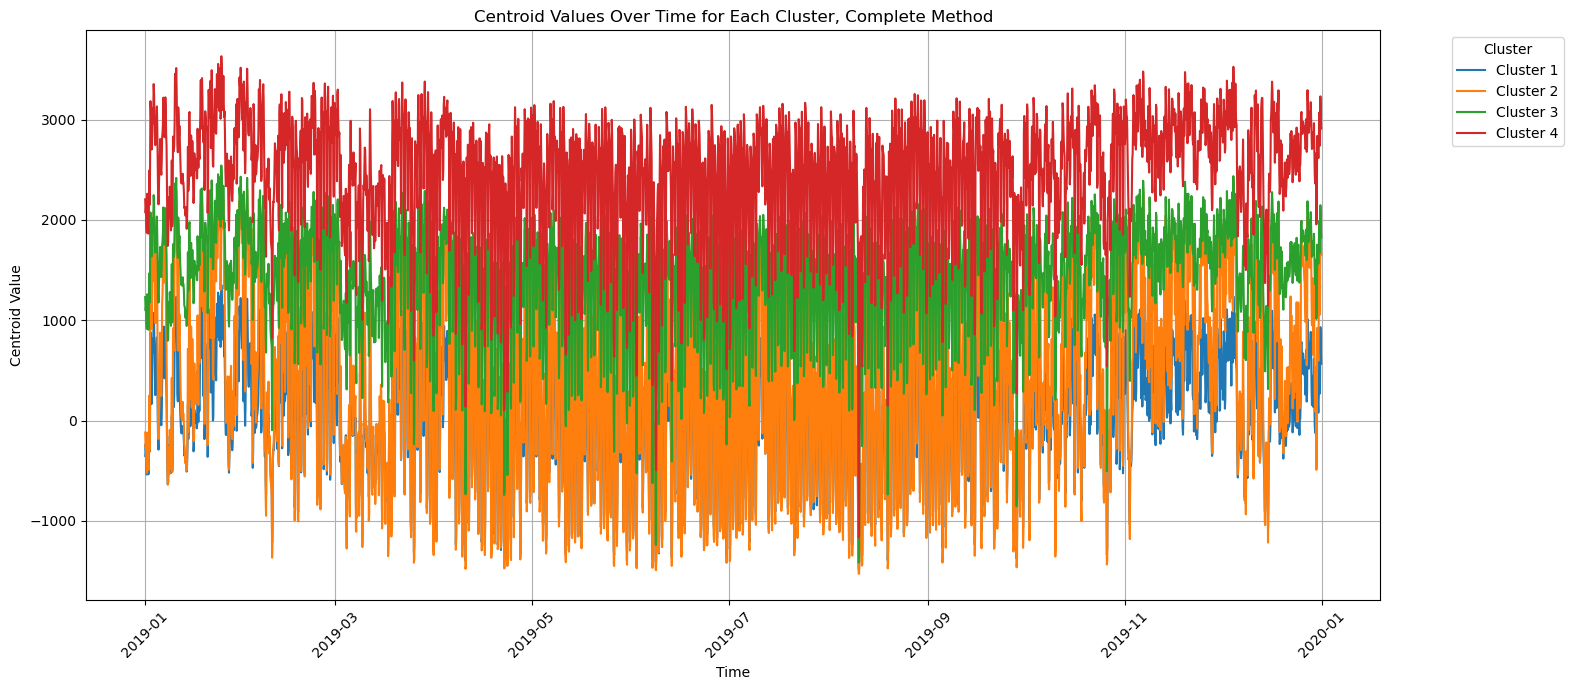

In [21]:
# Let's plot the data (one line for each cluster)
plt.figure(figsize=(14, 7))

# Loop through each cluster (row) and plot its centroid values over time (columns)
for cluster in cluster_summary.index:
    plt.plot(cluster_summary.columns, cluster_summary.loc[cluster], label=f'Cluster {cluster}')

# Add titles and labels
plt.title('Centroid Values Over Time for Each Cluster, Complete Method')
plt.xlabel('Time')
plt.ylabel('Centroid Value')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Finds the configuration closest to the centroid for each cluster (the most representative configuration) and plots their time series.

Cluster 4 - Shape of cluster_configs: (66, 2920)
Cluster 2 - Shape of cluster_configs: (27, 2920)
Cluster 1 - Shape of cluster_configs: (55, 2920)
Cluster 3 - Shape of cluster_configs: (3, 2920)
Representative configurations: ['minpv_spore_7', 'minpv_spore_1', 'maxhtp_spore_3', 'minpv_spore_3']


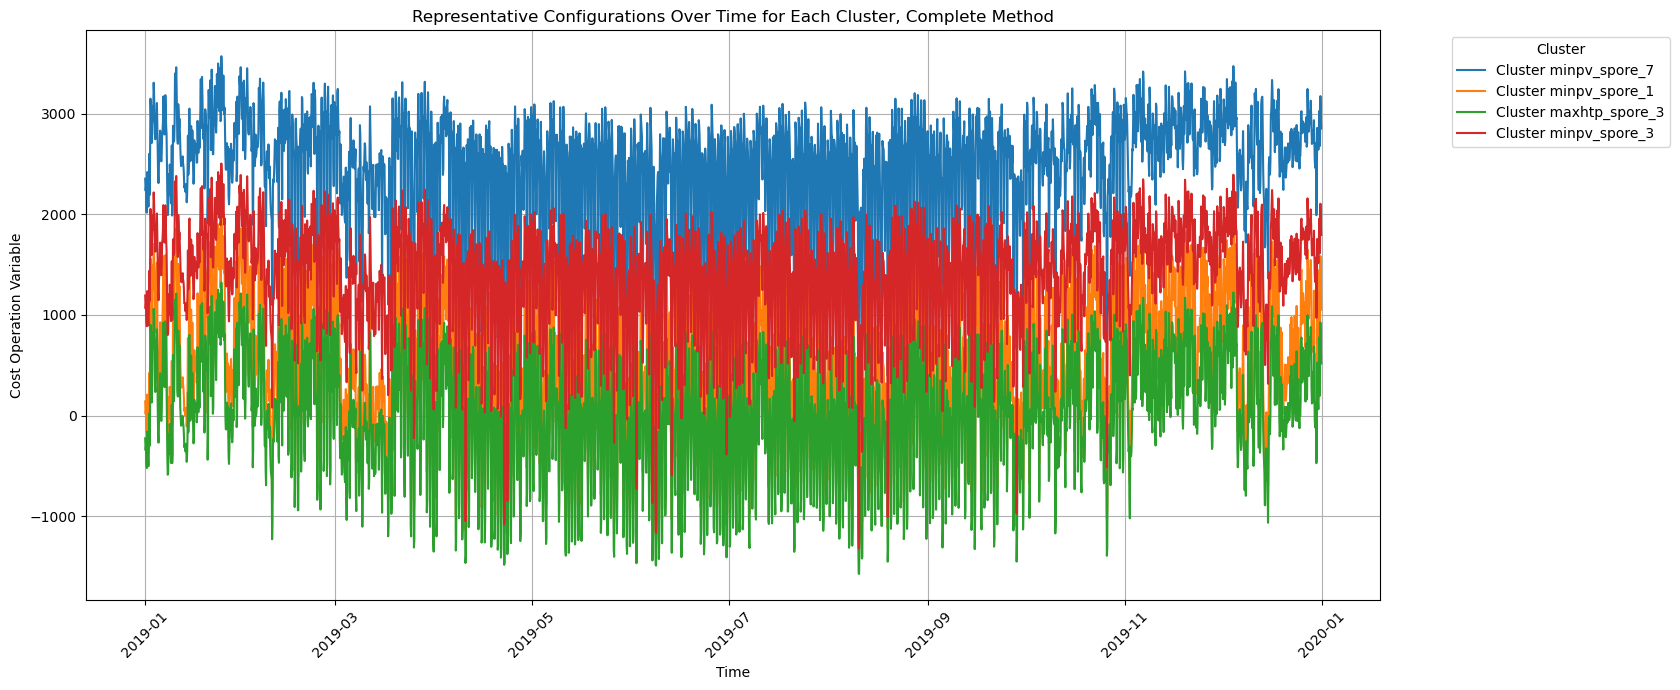

In [22]:
# Assuming 'aggregated_matrix' is your DataFrame with the 'Cluster' and technology columns

# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster_Hierarchical').mean()

# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster_Hierarchical'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster_Hierarchical'] == cluster].drop(columns=['Cluster_Hierarchical'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs].drop(columns=['Cluster_Hierarchical'])

plt.figure(figsize=(14, 7))

# Loop through each configuration in 'df_representative_configs' and plot the time series for each cluster
for config in df_representative_configs.index:
    # Extract the time series for the current configuration
    config_data = df_representative_configs.loc[config]
    
    # Plot the configuration over time
    plt.plot(df_representative_configs.columns, config_data, label=f'Cluster {config}')

# Customize the plot
plt.title('Representative Configurations Over Time for Each Cluster, Complete Method')
plt.xlabel('Time')
plt.ylabel('Cost Operation Variable')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Computes summary statistics (max, min, mean, variance, standard deviation, range, percentiles) for each representative configuration and displays them in a DataFrame.

In [23]:
# 1. Compute the metrics for each configuration
metrics = {
    'max_value': df_representative_configs.max(axis=1),
    'min_value': df_representative_configs.min(axis=1),
    'mean_value': df_representative_configs.mean(axis=1),
    'variance_value': df_representative_configs.var(axis=1),
    'std_dev_value': df_representative_configs.std(axis=1),
    'range_value': df_representative_configs.max(axis=1) - df_representative_configs.min(axis=1),
    'percentile_25': df_representative_configs.quantile(0.25, axis=1),
    'percentile_50': df_representative_configs.quantile(0.5, axis=1),
    'percentile_75': df_representative_configs.quantile(0.75, axis=1),
}

# Convert the metrics to a DataFrame for easy visualization
metrics_df = pd.DataFrame(metrics)

metrics_df

,max_value,min_value,mean_value,variance_value,std_dev_value,range_value,percentile_25,percentile_50,percentile_75
minpv_spore_7,3571.769641,-1154.630726,2450.252203,348544.135806,590.376266,4726.400367,2218.546831,2617.808551,2843.336021
minpv_spore_1,1990.668277,-1331.097769,508.643502,446313.027338,668.066634,3321.766046,77.490870,518.460267,999.255562
maxhtp_spore_3,1322.353676,-1573.858030,27.356729,334046.122447,577.967233,2896.211706,-309.556801,54.947023,472.087983
minpv_spore_3,2504.868997,-1319.755504,1392.947441,272313.619347,521.836775,3824.624502,1120.377490,1495.311582,1765.910492


Performs linear regression on each representative configuration's time series to calculate the slope (trend) of each configuration.

In [24]:
from scipy.stats import linregress

# 1. Perform linear regression for each representative configuration
# and calculate the slope of the regression line
slopes = []
for config in df_representative_configs.index:
    time = np.arange(len(df_representative_configs.columns))  # Time indices for each timestep
    y = df_representative_configs.loc[config].values
    slope, _, _, _, _ = linregress(time, y)
    slopes.append(slope)

slopes = pd.Series(slopes, index=df_representative_configs.index, name='Slope')
slopes_df = pd.DataFrame(slopes).reset_index()
slopes_df.columns = ['Representative Configuration', 'Slope']
print(f"Slopes of the linear regression for each representative configuration: {slopes}")

slopes_df = pd.DataFrame(slopes).reset_index()
slopes_df.columns = ['Representative Configuration', 'Slope']

Slopes of the linear regression for each representative configuration: minpv_spore_7     0.035632
minpv_spore_1     0.039321
maxhtp_spore_3    0.032880
minpv_spore_3     0.032699
Name: Slope, dtype: float64


Plots the time series of each representative configuration along with its linear regression trend line for visual comparison.

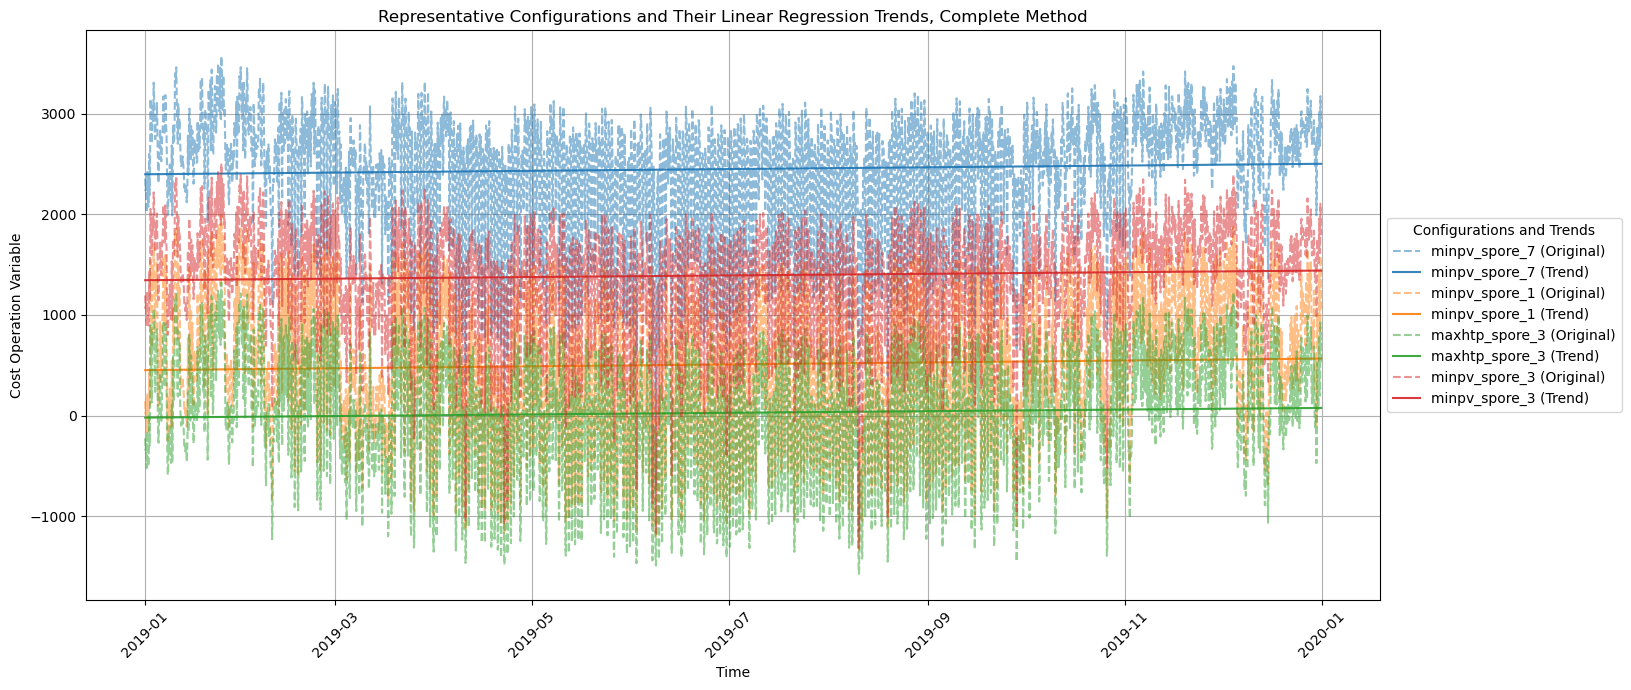

In [25]:
from scipy.stats import linregress
import matplotlib.cm as cm
# Plotting the representative configurations and their linear regression trends

# Initialize the plot
plt.figure(figsize=(14, 7))

# Loop through each representative configuration (row in df_representative_configs)
for i, config in enumerate(df_representative_configs.index):
    # Extract the time series for the current configuration
    config_data = df_representative_configs.loc[config]
    
    # Perform linear regression to get the slope and intercept
    time = np.arange(len(config_data))  # Time indices for each timestep
    slope, intercept, _, _, _ = linregress(time, config_data.values)
    
    # Generate the regression line (linear trend)
    regression_line = slope * time + intercept
    
    # Use a colormap to assign a unique color for each configuration
    base_color = cm.tab10(i % 10)
    
    # Plot the configuration over time
    plt.plot(df_representative_configs.columns, config_data, label=f'{config} (Original)', linestyle='--', color=base_color, alpha=0.5)

    # Plot the linear regression line
    trend_color = base_color
    plt.plot(df_representative_configs.columns, regression_line, label=f'{config} (Trend)', linestyle='-', color=trend_color, alpha=0.9)

# Customize the plot
plt.title('Representative Configurations and Their Linear Regression Trends, Complete Method')
plt.xlabel('Time')
plt.ylabel('Cost Operation Variable')
plt.xticks(rotation=45)  # Rotate time labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Configurations and Trends')
plt.show()

In [26]:
with pd.ExcelWriter('results/output_hierarchical_time_Complete.xlsx', engine='openpyxl') as writer:
    cluster_spore_count.to_excel(writer, sheet_name='spore_count', index=True)
    cluster_summary.to_excel(writer, sheet_name='cluster_summary', index=True)
    df_representative_configs.to_excel(writer, sheet_name='representative_configs', index=True)
    metrics_summary.to_excel(writer, sheet_name='metrics_summary', index=False)
    metrics_df.to_excel(writer, sheet_name='statistics', index=True)
    slopes_df.to_excel(writer, sheet_name='slopes', index=False)